In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/5001/

/content/drive/MyDrive/5001


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Data Processing

In [4]:
data=pd.read_csv('Trip.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660230 entries, 0 to 660229
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         660230 non-null  int64  
 1   duration           660230 non-null  float64
 2   bike_id            660230 non-null  int64  
 3   subscription_type  660230 non-null  object 
 4   date               660230 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 25.2+ MB


In [6]:
data['duration']=pd.to_numeric(data['duration'],errors='coerce')
data['date']=pd.to_datetime(data['date'],format='%Y-%m-%d',errors='coerce')

In [7]:
data.head()


,Unnamed: 0,duration,bike_id,subscription_type,date
0,0,1.050000,520,Subscriber,2013-08-29
1,1,1.883333,553,Subscriber,2013-08-29
2,2,2.800000,598,Subscriber,2013-08-29
3,3,4.366667,587,Subscriber,2013-08-29
4,4,16.583333,327,Subscriber,2013-08-29


In [8]:
#思路：分析坏车需要考虑到：①使用总时长 ②坏车从开始使用到现有的年数 ③公里数无法获得
data=data.sort_values(['date'],ascending=True)
data_group=data.groupby('bike_id')

In [9]:
tmp=dict(list(data_group))
tmpname=[]
tmpname = [i for i,j in data_group]
ans_df = pd.concat(tmp,ignore_index = True)


In [10]:
total_time=[]
avg_time=[]
use_times=[]
time_duration=[]
for i in tmpname:
    ans_df=pd.DataFrame(tmp[i])
    sum_time=ans_df['duration'].sum()
    total_time.append(sum_time)
    mean_time=ans_df['duration'].mean()
    avg_time.append(mean_time)
    u_times=ans_df['duration'].count()
    use_times.append(u_times)
    days=ans_df['date'].iloc[-1]-ans_df['date'].iloc[0]
    time_duration.append(days)    

In [11]:
time_duration=pd.DataFrame(time_duration)
time_duration=time_duration.astype('timedelta64[D]').astype(float)
#time_duration

In [12]:
days_duration=time_duration.iloc[:,0].values.tolist()
days_duration=pd.Series(days_duration)

In [13]:
tmpname=pd.Series(tmpname)
total_time=pd.Series(total_time)
avg_time=pd.Series(avg_time)
use_times=pd.Series(use_times)
new_data=pd.concat([tmpname,total_time,avg_time,use_times,days_duration],axis=1)
new_data.columns=['tmpname','total_time','avg_time','use_times','days_duration']
new_data.head()

,tmpname,total_time,avg_time,use_times,days_duration
0,9,3139.383333,12.866325,244,718.0
1,10,2908.033333,12.116806,240,729.0
2,11,2298.850000,13.061648,176,673.0
3,12,3483.733333,18.729749,186,723.0
4,13,3815.066667,17.031548,224,732.0


# Plot & Model

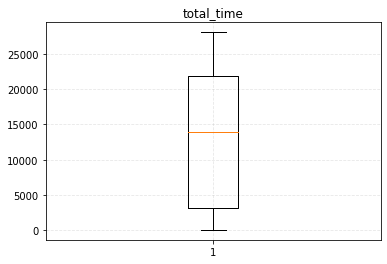

In [14]:
#可以理解为异常值检测的变型 方法：①箱线图 ②DBSCAN

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
#Variable
ax.boxplot(new_data['total_time'])
plt.grid(linestyle="--", alpha=0.3)
plt.title('total_time')
plt.show()

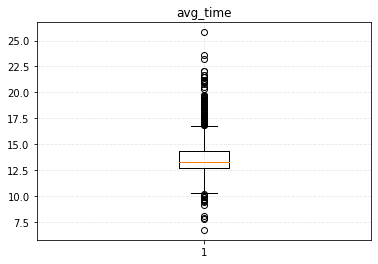

In [15]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
#Variable
ax.boxplot(new_data['avg_time'])
plt.grid(linestyle="--", alpha=0.3)
plt.title('avg_time')
plt.show()

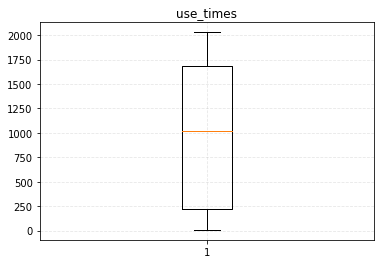

In [16]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
#Variable
ax.boxplot(new_data['use_times'])
plt.grid(linestyle="--", alpha=0.3)
plt.title('use_times')
plt.show()

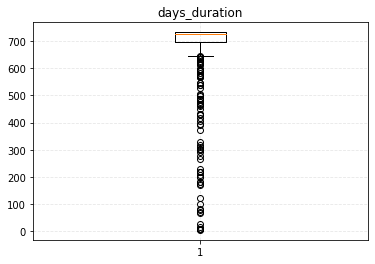

In [17]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
#Variable
ax.boxplot(new_data['days_duration'])
plt.grid(linestyle="--", alpha=0.3)
plt.title('days_duration')
plt.show()

In [18]:
from sklearn.cluster import DBSCAN

X = new_data[["total_time","avg_time","use_times","days_duration"]]
# 设置半径为10，最小样本量为2，建模
db = DBSCAN(eps=10, min_samples=2).fit(X)
 
labels = db.labels_ 
new_data['cluster_db'] = labels  # 在数据集最后一列加上经过DBSCAN聚类后的结果
new_data.sort_values('cluster_db')

# 注：cluster列是kmeans聚成3类的结果；cluster2列是kmeans聚类成2类的结果；scaled_cluster列是kmeans聚类成3类的结果（经过了数据标准化）


,tmpname,total_time,avg_time,use_times,days_duration,cluster_db
0,9,3139.383333,12.866325,244,718.0,-1
457,479,23199.400000,13.196473,1758,727.0,-1
458,480,22647.133333,12.978300,1745,726.0,-1
459,481,19098.166667,14.032452,1361,594.0,-1
460,482,21063.950000,13.018511,1618,730.0,-1
...,...,...,...,...,...,...
495,517,23477.100000,12.892422,1821,727.0,9
551,573,22089.700000,12.382119,1784,725.0,10
498,520,22096.500000,12.399832,1782,731.0,10
670,692,2945.666667,16.009058,184,695.0,11


In [19]:
print(new_data.groupby('cluster_db').mean())

               tmpname    total_time   avg_time    use_times  days_duration
cluster_db                                                                 
-1          371.967407  12703.147358  13.888934   956.220741      676.06963
 0          287.666667   3893.383333  14.637669   266.000000      730.00000
 1           91.500000   3597.816667  14.449251   249.000000      730.00000
 2          119.500000   2489.350000  11.421012   218.000000      726.50000
 3          146.500000   3172.625000  13.110021   242.000000      707.50000
 4          143.000000   3672.450000  16.143430   227.500000      729.50000
 5          165.500000   2857.016667  12.422609   230.000000      706.00000
 6          174.500000   2283.191667  13.235946   172.500000      723.50000
 7          481.000000   3235.433333  12.688749   255.000000      713.50000
 8          300.000000  21642.400000  13.438312  1610.500000      732.00000
 9          436.000000  23479.400000  12.911437  1818.500000      729.00000
 10         

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4b8af4750>
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa4d53cff80> (for post_execute):


KeyboardInterrupt: ignored

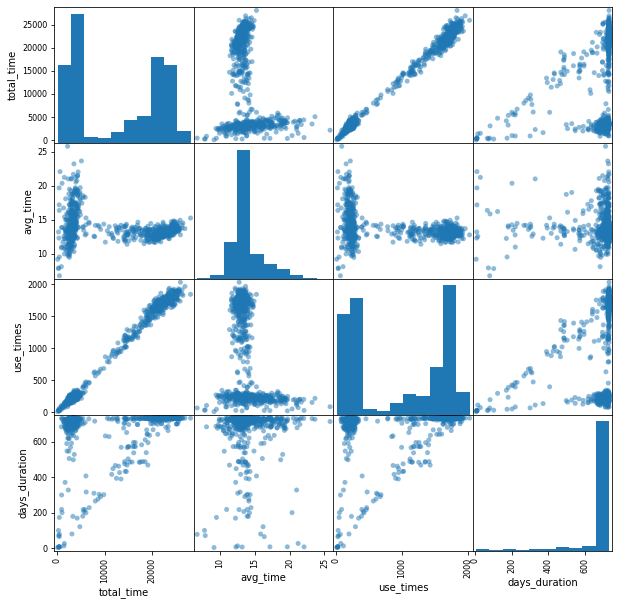

In [20]:
print(pd.plotting.scatter_matrix(X, figsize=(10,10), s=100))

In [21]:
# 我们可以从上面这个图里观察聚类效果的好坏，但是当数据量很大，或者指标很多的时候，观察起来就会非常麻烦。
from sklearn import metrics  
# 就是下面这个函数可以计算轮廓系数（sklearn真是一个强大的包）
score = metrics.silhouette_score(X,new_data.cluster_db) 
print(score)

-0.8008938503359118


### 由轮廓系数和上图的自动聚类的结果可知，使用DBSCAN进行聚类的效果并不好

# Data Analysis

### 构建一个综合得分体系，分别将new_data列的数据进行降序排序，序号即为得分，将综合得分最小的前几个id视为存在坏车

In [22]:
import numpy as np

In [23]:
orders=np.arange(1,len(new_data)+1,1)
orders=orders.tolist()

In [24]:
new_data['total_time']=pd.to_numeric(new_data['total_time'],errors='coerce')
new_data['avg_time']=pd.to_numeric(new_data['avg_time'],errors='coerce')
new_data['use_times']=pd.to_numeric(new_data['use_times'],errors='coerce')
new_data['days_duration']=pd.to_numeric(new_data['days_duration'],errors='coerce')

In [25]:
data_1=new_data.sort_values(by=["total_time"] , ascending=False) 
tmpname1=data_1["tmpname"].tolist()
total_time_rank=dict(zip(tmpname1,orders))
total_time_rank = sorted(total_time_rank.items(), key=lambda d: d[0], reverse=False)
total_time_rank=dict(total_time_rank)

In [26]:
data_2=new_data.sort_values(by=["avg_time"] , ascending=False) 
tmpname2=data_2["tmpname"].tolist()
avg_time_rank=dict(zip(tmpname2,orders))
avg_time_rank = sorted(avg_time_rank.items(), key=lambda d: d[0], reverse=False)
avg_time_rank=dict(avg_time_rank)

In [27]:
data_3=new_data.sort_values(by=["use_times"] , ascending=False) 
tmpname3=data_3["tmpname"].tolist()
use_times_rank=dict(zip(tmpname3,orders))
use_times_rank = sorted(use_times_rank.items(), key=lambda d: d[0], reverse=False)
use_times_rank=dict(use_times_rank)

In [28]:
data_4=new_data.sort_values(by=["days_duration"] , ascending=False) 
tmpname4=data_4["tmpname"].tolist()
days_duration_rank=dict(zip(tmpname4,orders))
days_duration_rank = sorted(days_duration_rank.items(), key=lambda d: d[0], reverse=False)
days_duration_rank=dict(days_duration_rank)

In [29]:
#得分表
lst=[total_time_rank,avg_time_rank,use_times_rank,days_duration_rank]
rank_result1=pd.DataFrame(lst)
rank_result=pd.DataFrame(rank_result1.values.T,index=rank_result1.columns, columns=rank_result1.index)
rank_result.columns=['total_time_rank','avg_time_rank','use_times_rank','days_duration_rank']
rank_result

,total_time_rank,avg_time_rank,use_times_rank,days_duration_rank
9,536,478,482,440
10,571,621,495,300
11,639,427,617,587
12,490,37,598,402
13,447,72,523,192
...,...,...,...,...
717,687,676,684,677
740,681,555,676,694
876,700,696,700,700
877,336,661,312,654


In [30]:
rank_result['row_mean'] = rank_result.mean(axis=1)

In [31]:
#将坏车数量定为70（占所有车辆数的10%）
final_result=rank_result.sort_values(by=["row_mean"] , ascending=True)
broken_bike=final_result.head(70)
broken_bike

,total_time_rank,avg_time_rank,use_times_rank,days_duration_rank,row_mean
592,4,255,8,57,81.00
613,1,126,31,172,82.50
587,21,177,92,55,86.25
326,5,183,28,135,87.75
524,13,321,14,4,88.00
...,...,...,...,...,...
348,70,403,55,131,164.75
371,91,267,152,149,164.75
390,116,280,175,97,167.00
266,76,218,167,208,167.25


In [32]:
broken_bike.to_csv('broken_bikeid.csv')